# Streaming Gaussian Process Minimum Viable Code

A quick notebook to show a GPflow implementation of a simple 1D streaming GP. 

In [1]:
%matplotlib inline
import itertools
import numpy as np
import time
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
from gpflow.utilities import print_summary, set_trainable, deepcopy
from IPython.display import clear_output
from tensorflow_probability import distributions as tfd
# for reproducibility of this notebook:
tf.random.set_seed(42)

## Define optimizers, loss functions etc.

In [2]:
def run_adam(model, iterations, data):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    :param data: observed data set
    :return logf: model training loss
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure(data)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    # Optimize variational parameters 
    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            loss = -training_loss().numpy()
            logf.append(loss)
            clear_output(wait=True)
            print("iteration {}".format(step))
    return logf

In [3]:
def run_continuous_opt(
    old_model,
    new_model,
    data,
    Znew,
    Zold,
    optimizer = None,
    maxiter=1e3,
    compile=False,
):
    """
    Training loop for continuous loss function Lc

    :param old_model: GPflow model
    :param new_model: GPflow model
    :param data: observed data set
    :param Znew: inducing points of new_model
    :param Zold: inducing points of old_model
    :param optimizer: tf.optimizers or tf.keras.optimizers that updates variables by applying the
        corresponding loss gradients. Adam is a default optimizer with default settings.
    :param maxiter: maximum number of iterations
    :return step: iteration number
    :return LC: model continuous training loss at step
    """
    
    # Initialise optimizer and get continuous covariance matrix Kuu and mean mu_uu
    step = []
    Lc = []
    KL = []
    
    optimizer = tf.optimizers.Adam() if optimizer is None else optimizer
    var_list = new_model.trainable_variables
    Kuu, mu_uu = get_Kuu(old_model, Znew, Zold)
    
    def optimization_step():
        ''' Optimization step, returns model loss'''
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(var_list)
            # Calls elbo function which returns Lc, the continuous lower-bound and KL divergences
            f = elbo(new_model,old_model,data,Znew,Zold,Kuu,mu_uu)
            loss = -f[0]
            KL = f[1]
        grads = tape.gradient(loss, var_list)
        optimizer.apply_gradients(zip(grads, var_list))
        return loss, KL
    
    if compile:
        optimization_step = tf.function(optimization_step)

    # Optimize variational parameters
    for iter in range(int(maxiter)):
        loss, KLstep = optimization_step()
        if iter % 10 == 0:
            step.append(iter)
            Lc.append(loss)
            KL.append(KLstep)
            clear_output(wait=True)
            print("iteration {}".format(iter))
            
    return step, Lc, KL

In [4]:
@tf.function
def elbo(new_model,old_model,data,Znew,Zold,Kuu,mu_uu):
    
    """
    Function to compute continuous lower-bound Lc.
    
    :param new_model: GPflow model
    :param old_model: GPflow model    
    :param data: observed data set Dnew
    :param Znew: inducing points of new_model
    :param Zold: inducing points of old_model
    :param Kuu: continuous covariance matrix
    :param mu_uu: continuous mean
    :return LC: model continuous training loss at step
    :return KL: KL divergences of prior and posterior distributions
    """
    
    X, Y = data
    
    # get mean and variance of latent function at new data points
    f_mean, f_var = new_model.predict_f(X)
    var_exp = new_model.likelihood.variational_expectations(f_mean, f_var, Y)
    # compute variational expectation
    var_exp = tf.reduce_sum(var_exp)
    # get p(u_new|psi_old) and p(u_new,psi_new)
    Kold = old_model.kernel(Znew)
    Knew = new_model.kernel(Znew)
    
    q_mu = new_model.q_mu
    q_sqrt = new_model.q_sqrt
    
    # compute KL divergences with posterior variational params of new GP
    KL_q_pnew = get_KL(q_mu, q_sqrt, Knew)
    KL_q_pold = get_KL(q_mu, q_sqrt, Kold)
    KL_q_qold = get_KL(q_mu, q_sqrt, Kuu, mu_uu)
    
    # compute lower bound Lc
    Lc = var_exp - KL_q_pnew + KL_q_pold - KL_q_qold
    KL = [KL_q_pnew, KL_q_pold, KL_q_qold]
    
    return Lc, KL

In [5]:
def get_Kuu(old_model, Znew, Zold):
    
    """
    Function to compute the variational posterior mean and covariance matrix
    
    :param old_model: GPflow model
    :param Znew: inducing points of new_model
    :param Zold: inducing points of old_model
    :return Kuu: continuous covariance matrix
    :return mu_uu: continuous mean
    """
    
    K = old_model.kernel
    
    Kxx = K(Znew)
    Kxm = K(Znew, Zold)
    Kmm = K(Zold, Zold)
    Kmminv = tf.linalg.inv(Kmm)
    Kmx = tf.transpose(Kxm)
    L_u = old_model.q_sqrt
    A = tf.tensordot(L_u, tf.transpose(L_u),axes=1)[:,:,:,0]
    B = Kmminv @ A @ Kmminv
    
    Kuu = (
            Kxx - 
            (Kxm @ Kmminv @ Kmx) +
            (Kxm @ B @ Kmx)
            )
    
    mu_uu = Kxm @ Kmminv @ old_model.q_mu
    
    return Kuu, mu_uu

In [6]:
def get_KL(q_mu, q_sqrt, K, mu=None):
    
    """
    Function to compute KL divergences of given covariance matrix and posterior variational parameters
    
    :param q_mu: mean of variational posterior of new model
    :param q_mu: cholesky of the covariance of variational posterior of new model
    :param K: covariance matrix of p(u_new | . )
    :param mu: optional, mean of p(u_new | . )
    :return KL: KL divergence of given distributions
    """
           
    if mu == None:
        pu = tfd.MultivariateNormalFullCovariance(covariance_matrix=K)
    else:
        pu = tfd.MultivariateNormalFullCovariance(mu[:,0], K)
        
    qu = tfd.MultivariateNormalTriL(q_mu[:,0],q_sqrt)    
    
    KL = tfd.kl_divergence(qu,pu)
    
    return KL

## Define datasets

We use a synthetic 1D dataset of 10000 points

Text(0.5, 1.0, 'True f(X)')

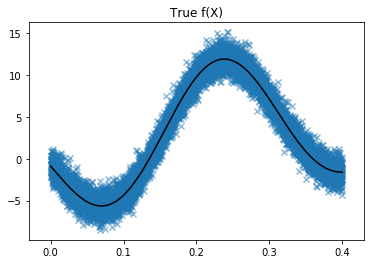

In [7]:
N = 10000
max_X = 0.4
X = np.sort(max_X*np.random.rand(N))[:, None]
def true_f(X_input):
    return (4.5 * np.cos(2 * np.pi * X_input + 1.5*np.pi) - \
           3 * np.sin(4.3 * np.pi * X_input + 0.3 * np.pi) + \
           5 * np.cos(7 * np.pi * X_input + 2.4 * np.pi))    

Y = np.random.normal(true_f(X))

plt.scatter(X,Y, alpha=0.5,marker="x")
Xt = np.linspace(0, max_X, N)[:, None]
Yt = true_f(Xt)
_ = plt.plot(Xt, Yt, c="k")
plt.title("True f(X)")

For this example, we split the data into 2 batches, optimize the first batch as for any other SVGP and then apply continuous optimization to the second batch

Text(0.5, 1.0, 'Data split into 2 batches')

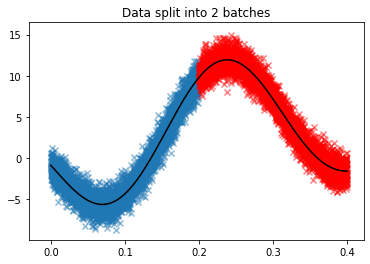

In [8]:
Xold = X[0:int(len(X)/2)]
Xnew = X[int(len(X)/2):]
Yold = np.random.normal(true_f(Xold))
Ynew = np.random.normal(true_f(Xnew))

data_old = (Xold, Yold)
data_new = (Xnew, Ynew)

plt.scatter(Xold,Yold,alpha=0.5,marker="x")
plt.scatter(Xnew,Ynew, c="r",alpha=0.5,marker="x")
Xt = np.linspace(0, 0.4, 1000)[:, None]
Yt = true_f(Xt)
_ = plt.plot(Xt, Yt, c="k")
plt.title("Data split into 2 batches")

In [9]:
# initialise inducing points and SVGP for first half of data
Zold = np.linspace(0,0.2,3)[:,None]
m_old = gpflow.models.SVGP(kernel = gpflow.kernels.SquaredExponential(),
                            likelihood = gpflow.likelihoods.Gaussian(), 
                            inducing_variable = Zold,
                            num_data = len(Xold))
gpflow.set_trainable(m_old.inducing_variable, False)
m_old

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(3, 1)",float64,[[0. ] [0.1] [0.2]]
SVGP.q_mu,Parameter,,,True,"(3, 1)",float64,[[0.] [0.] [0.]]
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 3, 3)",float64,"[[[1., 0., 0...."


Text(0.5, 1.0, 'Predictions before training')

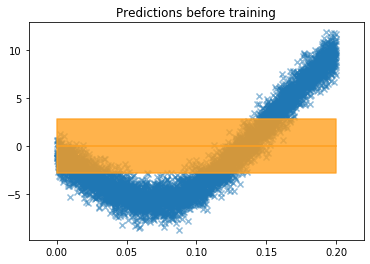

In [10]:
plt.scatter(Xold,Yold,alpha=0.5,marker="x")
Xt = np.linspace(0, max(Xold[:,0]), 100)[:, None]
Yt, Yv = m_old.predict_y(Xt)
_ = plt.plot(Xt, Yt, c="#ffa01f")
plt.fill_between(
        Xt[:, 0],
        (Yt - 2 * Yv ** 0.5)[:, 0],
        (Yt + 2 * Yv ** 0.5)[:, 0],        
        alpha=0.8,
        lw=1.5,
        color = "#ffa01f"
    )
plt.title("Predictions before training")

iteration 7990


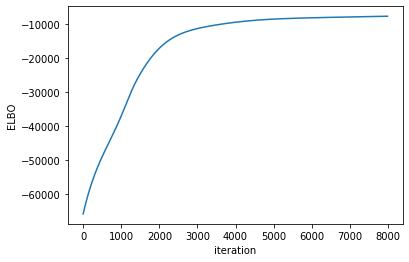

In [11]:
logf = run_adam(m_old, 8000, data_old)
plt.plot(np.arange(8000)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

Text(0.5, 1.0, 'Predictions after training')

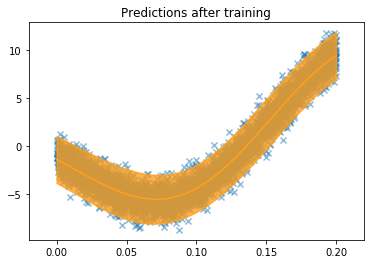

In [12]:
plt.scatter(Xold,Yold,alpha=0.5,marker="x")
Xt = np.linspace(0, max(Xold[:,0]), 100)[:, None]
Yt, Yv = m_old.predict_y(Xt)
_ = plt.plot(Xt, Yt, c="#ffa01f")
plt.fill_between(
        Xt[:, 0],
        (Yt - 2 * Yv ** 0.5)[:, 0],
        (Yt + 2 * Yv ** 0.5)[:, 0],        
        alpha=0.8,
        lw=1.5,
        color = "#ffa01f"
    )
plt.title("Predictions after training")

In [13]:
m_old

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.50810245385253
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.08329749327866787
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.497182920508028
SVGP.inducing_variable.Z,Parameter,,,False,"(3, 1)",float64,[[0. ] [0.1] [0.2]]
SVGP.q_mu,Parameter,,,True,"(3, 1)",float64,[[-0.65117975] [-2.00304328] [ 6.53853867]]
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 3, 3)",float64,"[[[0.02041015, 0., 0...."


In [30]:
# initialise inducing points and SVGP for second half of data
Znew = np.linspace(0,0.4,6)[:,None]

m_new = gpflow.models.SVGP(kernel = gpflow.utilities.deepcopy(m_old.kernel),
                            likelihood = gpflow.likelihoods.Gaussian(), 
                            inducing_variable = Znew)

gpflow.set_trainable(m_new.inducing_variable, False)

m_new

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.50810245385253
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.08329749327866787
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(6, 1)",float64,[[0....
SVGP.q_mu,Parameter,,,True,"(6, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 6, 6)",float64,"[[[1., 0., 0...."


Text(0.5, 1.0, 'New Data, predictions before training')

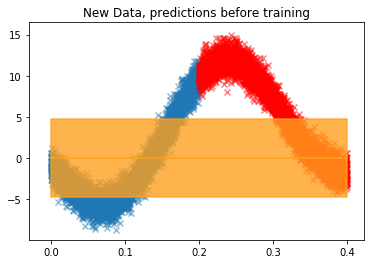

In [31]:
plt.scatter(Xold,Yold,alpha=0.5,marker="x")
plt.scatter(Xnew,Ynew,alpha=0.5,marker="x", color="r")
Xt = np.linspace(0, max(Xnew[:,0]), 100)[:, None]
Yt, Yv = m_new.predict_y(Xt)
_ = plt.plot(Xt, Yt, c="#ffa01f")
plt.fill_between(
        Xt[:, 0],
        (Yt - 2 * Yv ** 0.5)[:, 0],
        (Yt + 2 * Yv ** 0.5)[:, 0],        
        alpha=0.8,
        lw=1.5,
        color = "#ffa01f"
    )
plt.title("New Data, predictions before training")

In [32]:
step, Lc, KL = run_continuous_opt(m_old,m_new,data_new,Znew,Zold,maxiter=15000)

iteration 14990


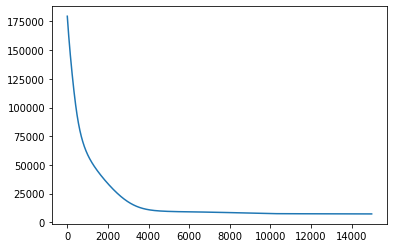

In [33]:
plt.plot(step,Lc)

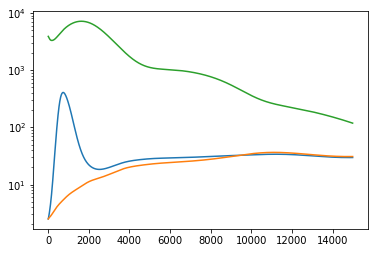

In [34]:
plt.plot(step,np.reshape(KL, (len(KL),3)))
plt.yscale("log")

Text(0.5, 1.0, 'New Data, predictions after training')

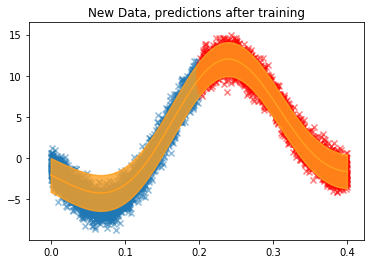

In [35]:
plt.scatter(Xold,Yold,alpha=0.5,marker="x")
plt.scatter(Xnew,Ynew,alpha=0.5,marker="x", color="r")
Xt = np.linspace(0, max(Xnew[:,0]), 100)[:, None]
Yt, Yv = m_new.predict_y(Xt)
_ = plt.plot(Xt, Yt, c="#ffa01f")
plt.fill_between(
        Xt[:, 0],
        (Yt - 2 * Yv ** 0.5)[:, 0],
        (Yt + 2 * Yv ** 0.5)[:, 0],        
        alpha=0.8,
        lw=1.5,
        color = "#ffa01f"
    )
plt.title("New Data, predictions after training")

In [36]:
m_new

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,9.23836751400153
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.09309173988025671
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0532806745018797
SVGP.inducing_variable.Z,Parameter,,,False,"(6, 1)",float64,[[0....
SVGP.q_mu,Parameter,,,True,"(6, 1)",float64,[[-0.68123093...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 6, 6)",float64,"[[[2.03281612e-02, 0.00000000e+00, 0.00000000e+00..."
